# Examples 

Below are some examples of how the package could be used in astronomical studies. While there are more use cases, the most common are outlined below.

## Examine an object

Let's start with the first example. Let one wants to identify all three-body and two-body resonances of an asteroid. One has to perform the following steps:

1. set up the model, including planets and their initial conditions;
2. add an object (or objects), which is examined;
3. find possible resonances, in which the object can be trapped in;
4. integrate the differential equations of motion for a long period of time (usually, $\approx 10^5$ yrs);
5. identify the resonant status of the object based on the analysis of the resonant angle, semi-major axis, and other variables.

Without loss of generality, let's examine the following case:

1. The target object is the asteroid 463 Lola.
2. The planets are Jupiter and Saturn for both, three-body and two-body cases.

To perform this, there is a function `find`.

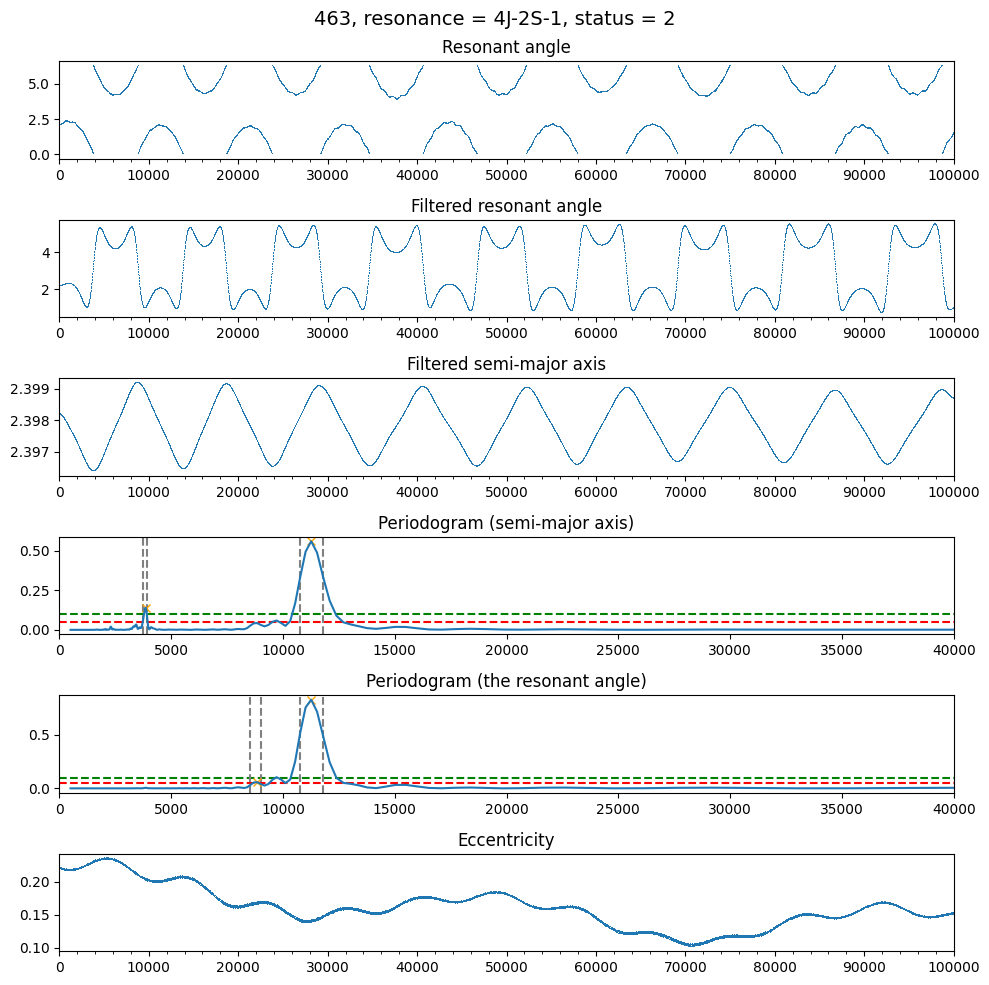

In [1]:
import resonances

sim = resonances.find(463, ['Jupiter', 'Saturn'])
sim.run()

From the plots, it is clear that only `4J-2S-1` is the only resonance, in which Lola is trapped in. Let's double-check this with the actual values.

In [2]:
df_summary = sim.get_simulation_summary()
df_summary.head(10)

,name,mmr,status,pure,num_libration_periods,max_libration_length,monotony,overlapping,a,e,inc,Omega,omega,M
0,463,2J+3S-1+0+0-4,0,False,106,1193.888189,0.006208,,2.397625,0.220008,0.236352,0.636863,5.751023,1.707801
1,463,4J-2S-1+0+0-1,2,True,1,100000.074689,0.505571,"(10774, 11801)",2.397625,0.220008,0.236352,0.636863,5.751023,1.707801
2,463,6J-7S-1+0+0+2,0,False,105,1782.873029,0.994110,,2.397625,0.220008,0.236352,0.636863,5.751023,1.707801
3,463,6J+1S-2+0+0-5,0,False,105,1751.036010,0.016714,,2.397625,0.220008,0.236352,0.636863,5.751023,1.707801
4,463,10J-3+0-7,0,False,2784,63.674037,1.000000,,2.397625,0.220008,0.236352,0.636863,5.751023,1.707801
5,463,8S-1+0-7,0,False,211,811.843968,0.003661,"(8398, 9009), (11264, 13045)",2.397625,0.220008,0.236352,0.636863,5.751023,1.707801
6,463,8S+1+0-9,0,False,2472,79.592546,1.000000,,2.397625,0.220008,0.236352,0.636863,5.751023,1.707801


Based on the dataframe, the only non-zero status is for the resonance `4J-2S-1`. The maximum libration length is greater than `60,000` years, which is good.

Therefore, we can claim that the asteroid 463 Lola is trapped in the transient resonance `4J-2S-1`.

The function `find` accepts different types of inputs:

The first parameter (`asteroids`) can be an asteroid's number, a string (for unnumbered asteroids), or a list of numbers. For example, you might want to examine simultaneously several objects:

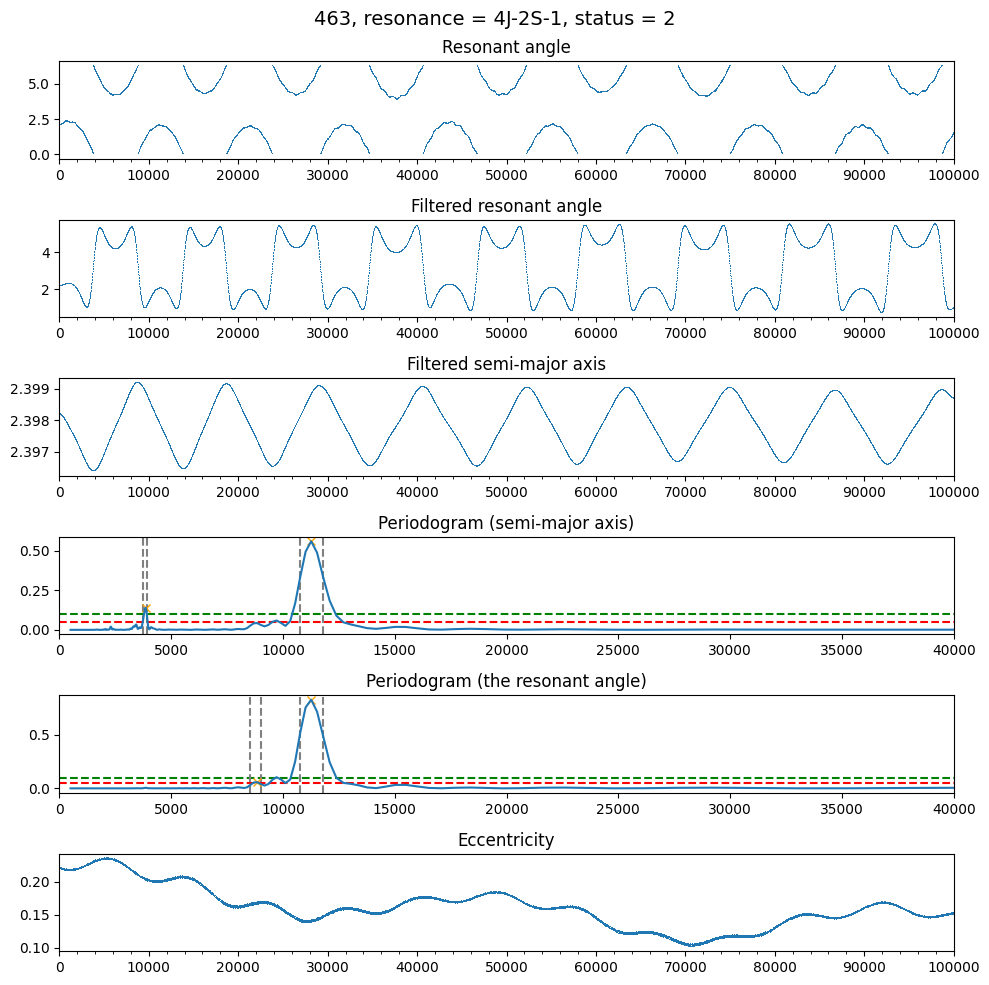

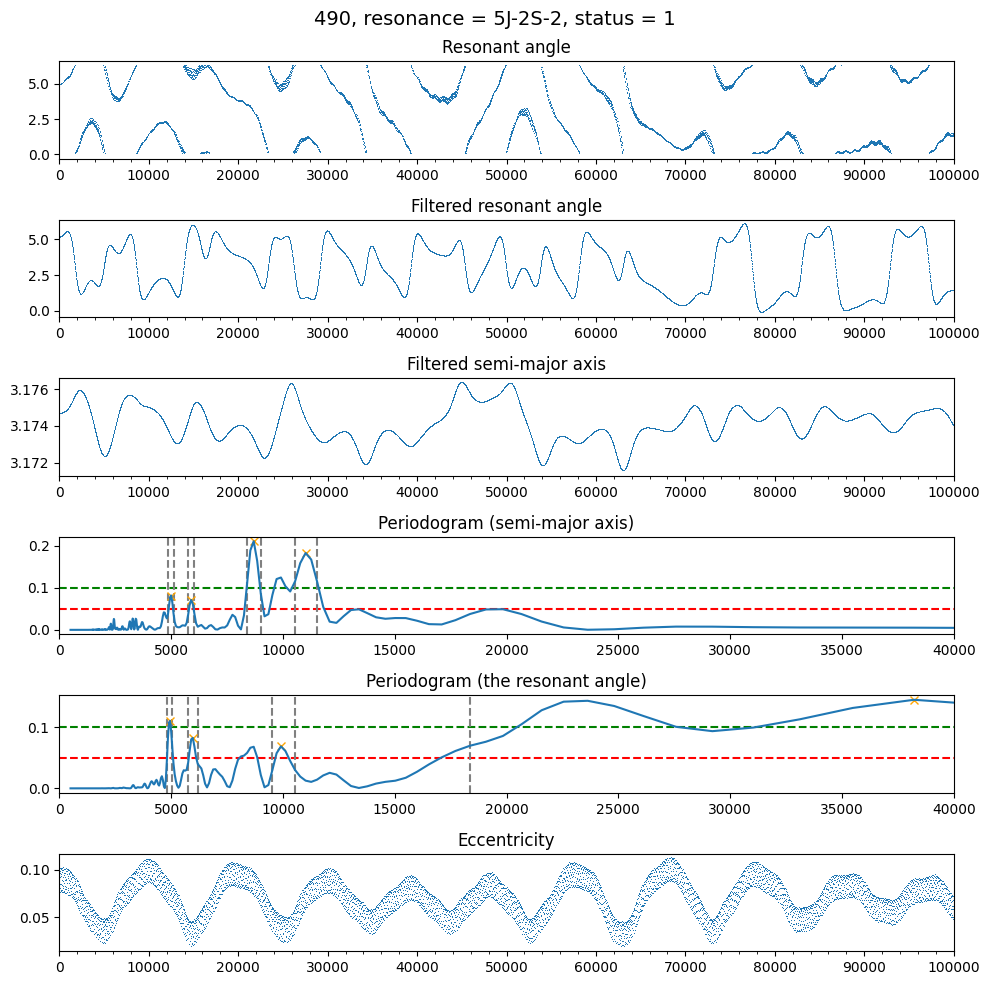

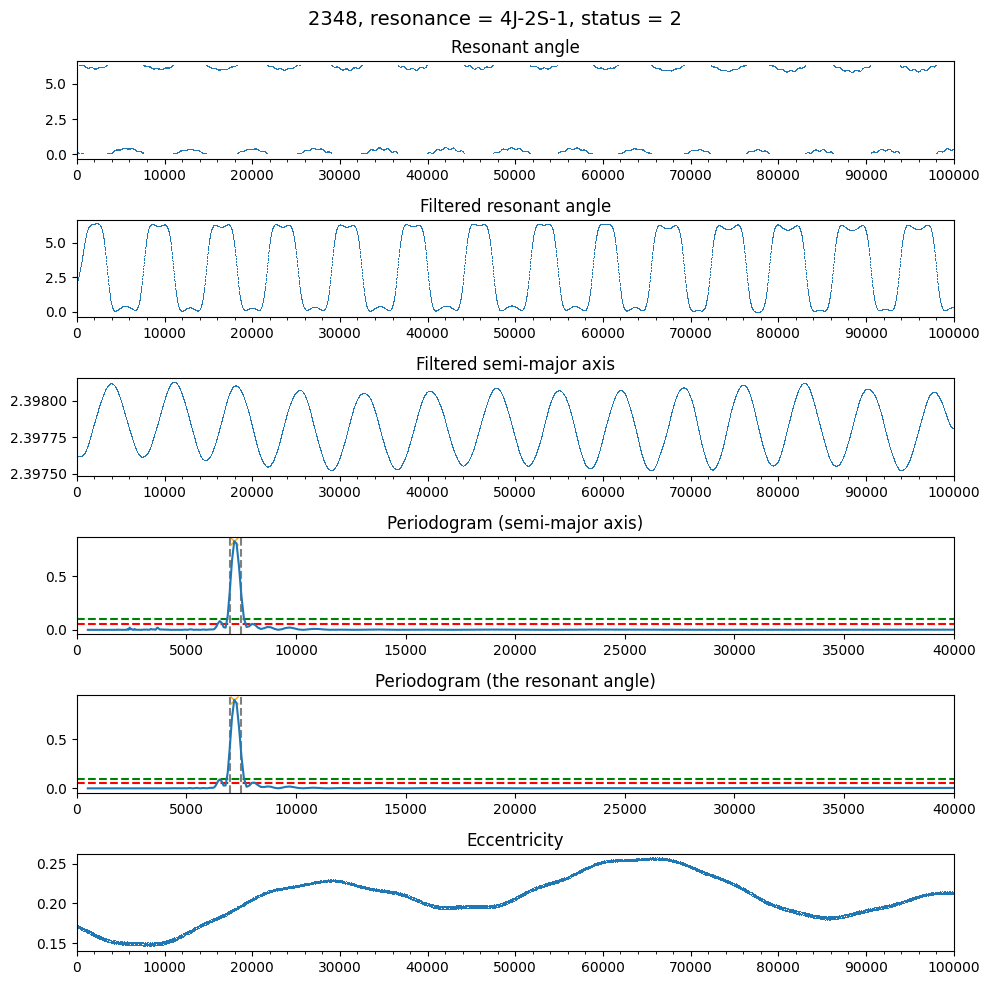

In [3]:
sim = resonances.find([463, 490, 2348], ['Jupiter', 'Saturn'])
sim.run()

Thus, all these asteroids are in resonances: 463 and 2348 — in 4J-2S-1, whereas 490 — in 5J-2S-2.

If you want to customise some variables, it is a good idea to check the original code, which is in `resonances/finder.py`:

In [5]:
from typing import Union, List
import astdys

def find(
    asteroids: Union[int, str, List[Union[int, str]]], planets=None, name: str = None, sigma2: float = 0.1, sigma3: float = 0.02
) -> resonances.Simulation:
    sim = resonances.Simulation(name=name)
    sim.create_solar_system()

    asteroids = convert_input_to_list(asteroids)

    elems = astdys.search(asteroids)
    for asteroid in asteroids:
        elem = elems[asteroid]
        mmrs = resonances.ThreeBodyMatrix.find_resonances(elem['a'], planets=planets, sigma=sigma3)
        mmrs2 = resonances.TwoBodyMatrix.find_resonances(elem['a'], planets=planets, sigma=sigma2)
        mmrs = mmrs + mmrs2
        if len(mmrs) > 0:
            sim.add_body(elem, mmrs, f"{asteroid}")
            resonances.logger.info(
                'Adding a possible resonance for an asteroid {} - {}'.format(asteroid, ', '.join(map(str, elems.values())))
            )
        else:
            resonances.logger.warning('No resonances found for an asteroid {}'.format(asteroid))

    return sim

Note that `find` function has three extra parameters:

- `name`: the name of the simulation that is used when saving the data in `cache/{name}` directory
- `sigma2` and `sigma3`: the distance between the calculated resonant semi-major axis value and the asteroids that will be examined. By default, the values are equal to `0.1` and `0.02`, respectively. However, for TNOs or under other circumstances, it is wise to reconsider these values, especially, for three-body MMRs because the resonant semi-major axis' value is not very accurate.

## Find resonances within a range

Let's imagine another task. Let one want to find what are the possible two-body mean-motions resonances between `2.3` and `2.4` AU.

In [6]:
from resonances import ThreeBodyMatrix, TwoBodyMatrix

In [7]:
mmrs = TwoBodyMatrix.find_resonances(2.35, sigma=0.05, planets=None)
for mmr in mmrs:
    print(mmr.to_short())

1V-6
1V+6
2E-7
2E+7
3E-11
10J-3
8S-1
8S+1


The code above performs the following:

1. `find_resonances` finds resonances within the range $2.35\pm 0.05 = [2.3, 2.4]$.
2. The option `planets` is set to `None`. Hence, the package will check all possible planets. One might specify conrete planets. For example:

In [8]:
mmrs = TwoBodyMatrix.find_resonances(2.35, sigma=0.05, planets=['Jupiter', 'Saturn'])
for mmr in mmrs:
    print(mmr.to_short())

10J-3
8S-1
8S+1


That's it. Now, one can perform any further action with the list of MMRs got. For three-body resonances, the algorithm is the same. The only difference is in the name of the class: `ThreeBodyMatrix` should be used.

## Find all asteroids in the resonance

One might want to examine a concrete resonance. In other words, one might want to find all asteroids that are trapped in this resonance.

Actually, we have two possible options here. We might want to find all asteroids that are close enough to the resonant value of semi-major axis. It does not confirm that they are trapped in the resonance. However, it shows that they **could** be. To confirm that, we have to integrate the orbits of these objects.

Let's start with the first task. To perform this, we need `astdys` component. Let's work with the resonance `6J-3S-2`.

In [9]:
import astdys

mmr = resonances.create_mmr('6J-3S-2')
df_asteroids = astdys.search_by_axis(mmr.resonant_axis, sigma=0.01)
print('Number of objects found: {}'.format(len(df_asteroids)))
df_asteroids.head(5)

Number of objects found: 4686


,a,e,inc,Omega,omega,M,epoch
num,,,,,,,
22,2.911063,0.098799,0.239143,1.151473,6.246673,3.349287,60400.0
191,2.896114,0.087409,0.201090,2.778376,3.953197,2.914869,60400.0
238,2.908355,0.091706,0.216576,3.208909,3.668466,0.131904,60400.0
307,2.908449,0.143681,0.106940,1.760447,5.645693,0.153178,60400.0
311,2.898233,0.005958,0.056271,1.413041,1.371173,1.263999,60400.0


There are many candidates. Now let's find whether any of them are resonant. To perform this, we can use a method `find_asteroids_in_mmr`

The parameter `sigma` specifies the half-width of the resonance, `per_iteration` — how many asteroids to integrate simultaneously (depends on your device, `500` by default).

In [35]:
data = resonances.find_asteroids_in_mmr('6J-3S-2', sigma=0.01)

By default, this method also saves output data to `cache/%current_datetime%` subdirectory. You can access the results either through the variable `data` or by reading `summary.csv` file in the proper directory.